# Data Storytelling

### Import libraries and load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, roc_auc_score,classification_report, fbeta_score, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant


import time
import datetime

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = 10, 10
sns.set()


In [2]:
ad = pd.read_excel('../EDA/advisor_table.xlsx')
ad.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1, inplace=True)

ad20 = pd.read_excel('../EDA/advisor20_table.xlsx')
ad20.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1, inplace=True)

df = pd.read_excel('processed_frame.xlsx')
df.drop('Unnamed: 0', axis=1, inplace=True)

df_school = pd.read_excel('frame_with_school.xlsx')
df_school.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
df_5 = df.drop('target_2',axis=1)
df_2 = df.drop('target_5',axis=1)

df_school_5 = df_school.drop('target_2',axis=1)
df_school_2 = df_school.drop('target_5',axis=1)

## Distribution of continuous target: `num_students_in_20_years`

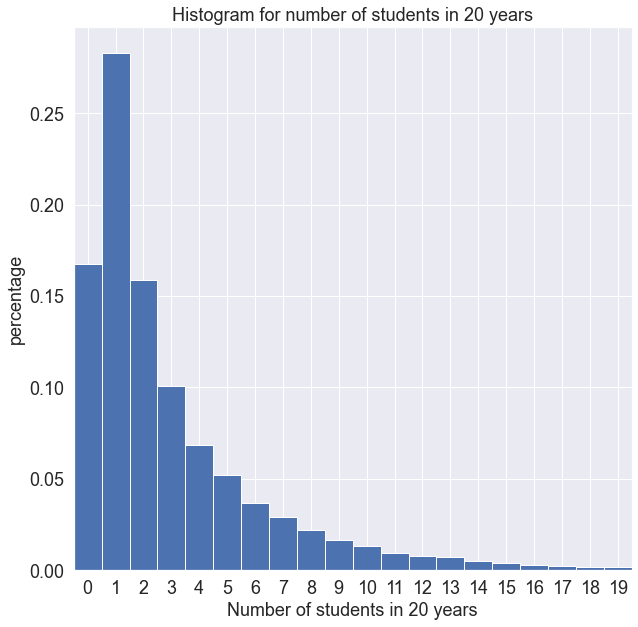

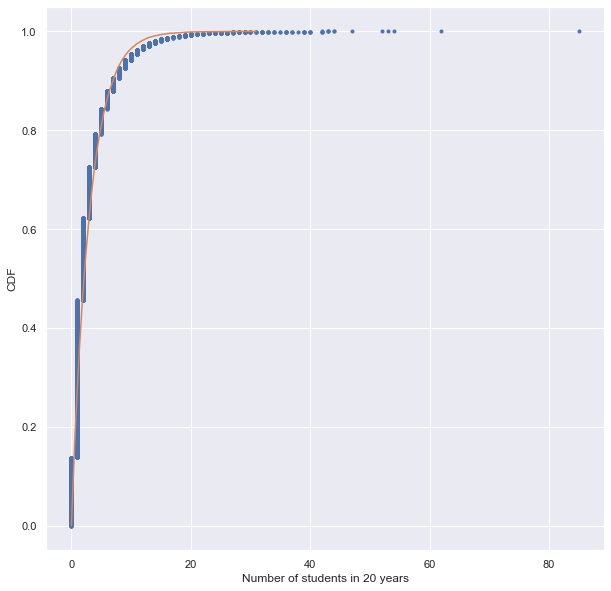

In [5]:
# histogram

bins = [i for i in range(50)]
plt.hist(ad[(ad['num_students']<100) & (ad['career_length']>= 20)]['num_students_in_20_years']\
    , bins = bins, density=True)
plt.title('Histogram for number of students in 20 years', fontsize=18)
plt.xlabel('Number of students in 20 years', fontsize=18)
plt.ylabel('percentage', fontsize=18)
plt.xlim(0,20)
plt.yticks(fontsize=18)
plt.xticks([i + 0.5 for i in range(0,20)],range(0,20), fontsize=18)
plt.savefig('../Report/num_students_in_20_years.jpeg')
plt.show()



def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1)/len(x)
    return x, y

#CDF against exponential

mean = np.mean(ad['num_students_in_20_years'])
samples = np.random.exponential(mean, size = 50000)
x, y = ecdf(ad['num_students_in_20_years'])
x_theor, y_theor = ecdf(samples)
plt.plot(x,y, marker='.', linestyle='none')
plt.plot(x_theor,y_theor)
plt.xlabel('Number of students in 20 years')
plt.ylabel('CDF')
plt.show()


## Heatmap

In [13]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

In [14]:
# define function to obtain correlation data   
def corr_array(data):    
    coef_df = pd.DataFrame({col:data.columns for col in data.columns})
    coef_df.index = data.columns

    for i in range(len(data.columns)):
        for j in range(i+1):
            if j == 0 and i > 0 and i < 5:
                coef_df.iloc[i,j] = stats.pointbiserialr(data.iloc[:,j],data.iloc[:,i])[0]
            elif i == 5 and j == 0:
                coef_df.iloc[i,j] = cramers_v(data.iloc[:,i],data.iloc[:,j])
            elif i == 5 and j> 0 and j < 5:
                coef_df.iloc[i,j] = correlation_ratio(data.iloc[:,i],data.iloc[:,j])
            elif i == j:
                coef_df.iloc[i,j] = 1    
            elif i > 0 and i < 5 and j > 0 and j < 5:
                coef_df.iloc[i,j] = np.corrcoef(data.iloc[:,i],data.iloc[:,j])[0][1]
            elif i == 6 and j in [0,5]:
                coef_df.iloc[i,j] = cramers_v(data.iloc[:,i],data.iloc[:,j])
            elif i == 6 and j>0 and j<5:
                coef_df.iloc[i,j] = stats.pointbiserialr(data.iloc[:,i],data.iloc[:,j])[0]
            elif i == 7 and j in [0,5,6]:
                coef_df.iloc[i,j] = cramers_v(data.iloc[:,i],data.iloc[:,j])
            elif i == 7 and j>0 and j<5:
                coef_df.iloc[i,j] = stats.pointbiserialr(data.iloc[:,i],data.iloc[:,j])[0]

    for i in range(len(data.columns)):
        for j in range(i+1, len(data.columns)):
            coef_df.iloc[i,j] = coef_df.iloc[j,i]

    return coef_df

As indicated by the regression analysis, `General Applied Mathematics` and `Difference and Functional Equations` are of interest for us to consider for the $\geq 5$ case.  Let's add them to `df_school_5`.

In [15]:
df_school_5['General applied mathematics'] = df.loc[:,'General applied mathematics']
df_school_5['Difference and functional equations'] = df.loc[:,'Difference and functional equations']

In [16]:
coef_df_5 = corr_array(df_school_5)
coef_df_5

,target_5,pubs_per_year,citations_per_pub,collabs_per_pub,Advisor_students_at_graduation,School,General applied mathematics,Difference and functional equations
target_5,1,0.194104,0.146384,0.046737,0.0599439,0.123386,0.0211204,0.0126873
pubs_per_year,0.194104,1,0.193088,-0.175754,0.0414567,0.200802,0.0142383,0.216935
citations_per_pub,0.146384,0.193088,1,-0.110461,0.0836104,0.194317,0.000695734,0.0201121
collabs_per_pub,0.046737,-0.175754,-0.110461,1,-0.0431285,0.208737,-0.0247359,-0.0816091
Advisor_students_at_graduation,0.0599439,0.0414567,0.0836104,-0.0431285,1,0.302896,-0.00238257,0.012618
School,0.123386,0.200802,0.194317,0.208737,0.302896,1,0.0510293,0.0964976
General applied mathematics,0.0211204,0.0142383,0.000695734,-0.0247359,-0.00238257,0.0510293,1,0.0367175
Difference and functional equations,0.0126873,0.216935,0.0201121,-0.0816091,0.012618,0.0964976,0.0367175,1


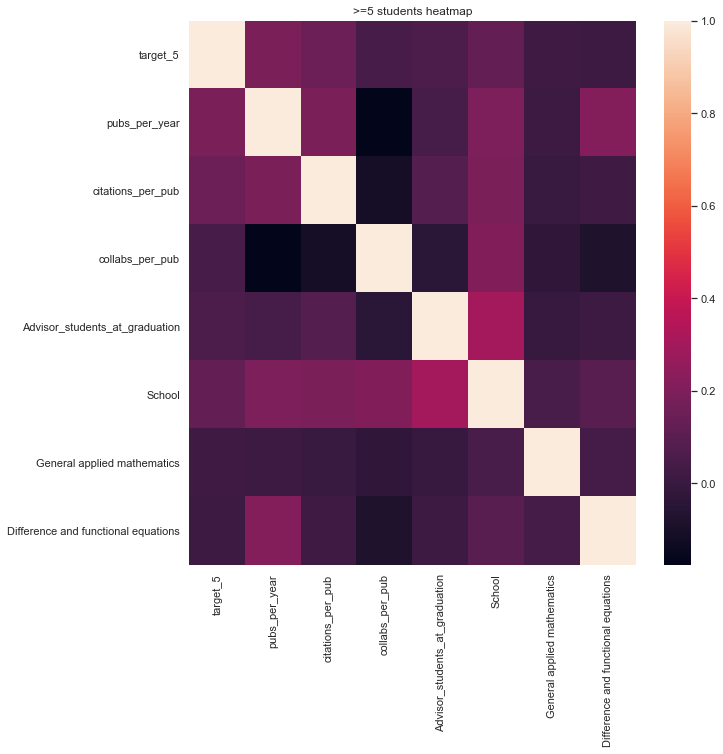

In [17]:
sns.heatmap(coef_df_5.astype('float'))
plt.title('>=5 students heatmap')
plt.show()

As indicated by the regression analysis for the $\geq 2$ students case, Miscellaneous and Mechanics are subjects of interest to consider in a correlation analysis.

In [18]:
df_school_2['Miscellaneous'] = df.loc[:,'Miscellaneous']
df_school_2['Mechanics'] = df.loc[:,'Mechanics']

In [19]:
coef_df_2 = corr_array(df_school_2)
coef_df_2

,target_2,pubs_per_year,citations_per_pub,collabs_per_pub,Advisor_students_at_graduation,School,Miscellaneous,Mechanics
target_2,1,0.17816,0.147398,0.0271382,0.0618303,0.101281,0.00460282,0.01313
pubs_per_year,0.17816,1,0.193088,-0.175754,0.0414567,0.200802,0.00358083,0.0196486
citations_per_pub,0.147398,0.193088,1,-0.110461,0.0836104,0.194317,-0.000316028,-0.00678934
collabs_per_pub,0.0271382,-0.175754,-0.110461,1,-0.0431285,0.208737,-0.0206309,-0.0449972
Advisor_students_at_graduation,0.0618303,0.0414567,0.0836104,-0.0431285,1,0.302896,0.0146832,-0.00603275
School,0.101281,0.200802,0.194317,0.208737,0.302896,1,0,0.0731174
Miscellaneous,0.00460282,0.00358083,-0.000316028,-0.0206309,0.0146832,0,1,0.00681888
Mechanics,0.01313,0.0196486,-0.00678934,-0.0449972,-0.00603275,0.0731174,0.00681888,1


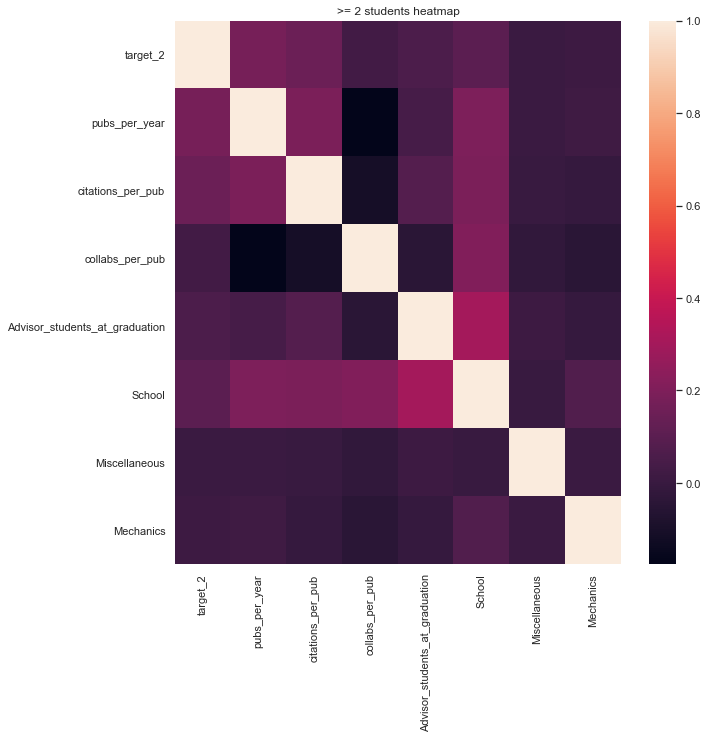

In [20]:
sns.heatmap(coef_df_2.astype('float'))
plt.title('>= 2 students heatmap')
plt.show()

## Some summary statistics

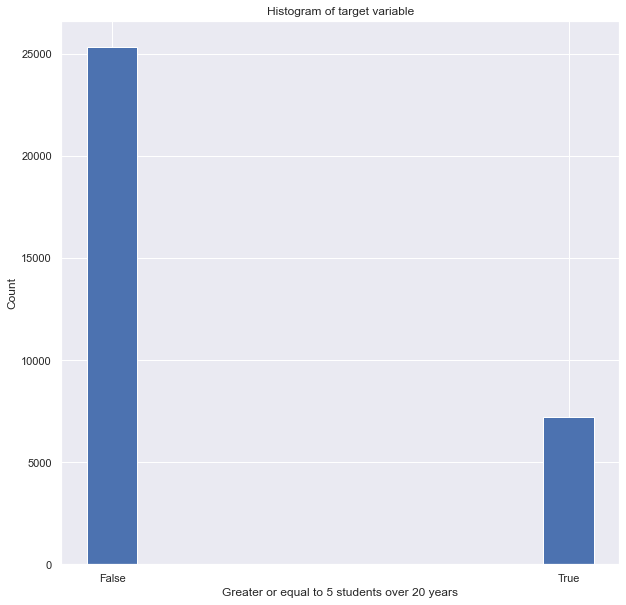

In [22]:
plt.hist(df_school.target_5.astype('int'))
plt.xlabel('Greater or equal to 5 students over 20 years')
plt.ylabel('Count')
plt.title('Histogram of target variable')
plt.xticks([0.05,0.95],[False,True])
plt.show()

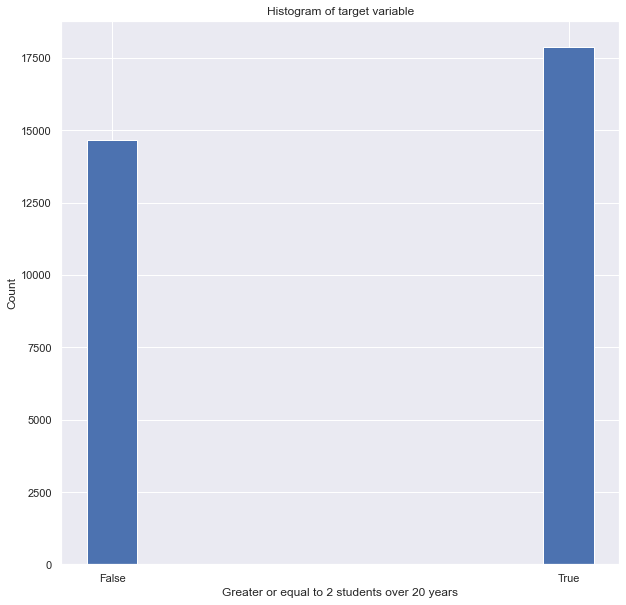

In [23]:
plt.hist(df_school.target_2.astype('int'))
plt.xlabel('Greater or equal to 2 students over 20 years')
plt.ylabel('Count')
plt.title('Histogram of target variable')
plt.xticks([0.05,0.95],[False,True])
plt.show()

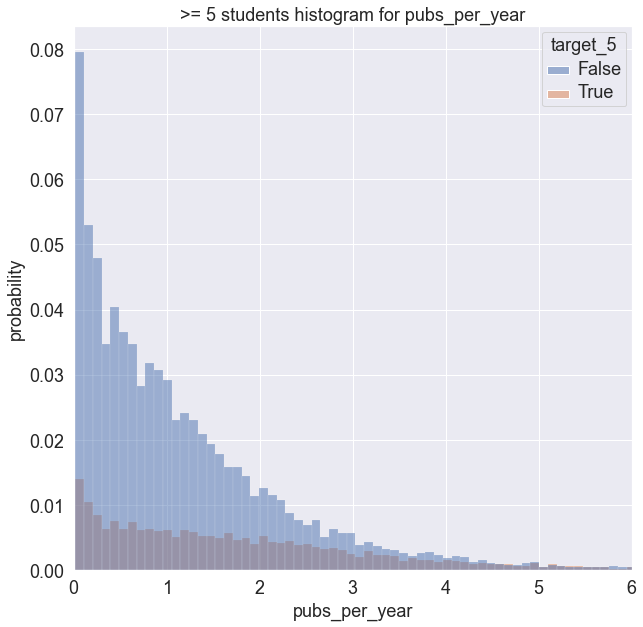

In [55]:
ax = sns.histplot(x = 'pubs_per_year', data=df_school_5, hue='target_5', stat='probability')
plt.xlim(0,6)
plt.title('>= 5 students histogram for pubs_per_year', fontsize=18)
plt.xlabel('pubs_per_year',fontsize=18)
plt.ylabel('probability',fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.setp(ax.get_legend().get_texts(), fontsize='18') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='18')
plt.savefig('../Report/pubs_per_year_hist_5.jpeg')
plt.show()

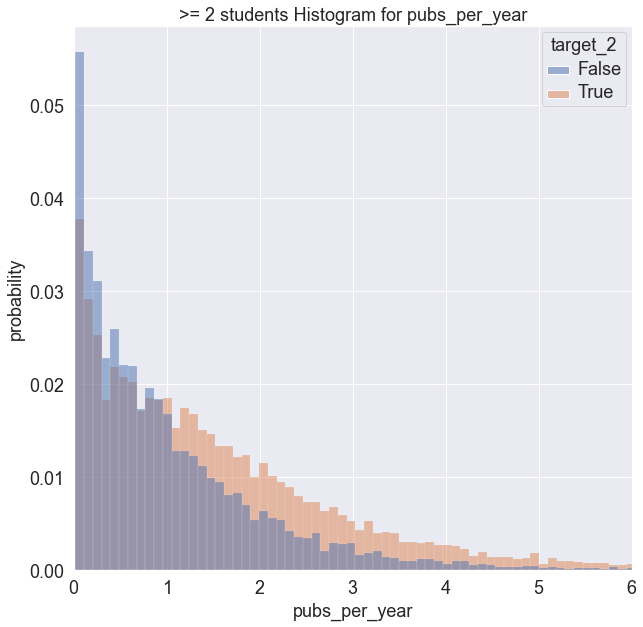

In [56]:
ax = sns.histplot(x = 'pubs_per_year', data=df_school_2, hue='target_2', stat='probability')
plt.xlabel('pubs_per_year',fontsize=18)
plt.ylabel('probability',fontsize=18)
plt.xlim(0,6)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('>= 2 students Histogram for pubs_per_year', fontsize=18)
plt.setp(ax.get_legend().get_texts(), fontsize='18') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='18')
plt.savefig('../Report/pubs_per_year_hist_2.jpeg')
plt.show()

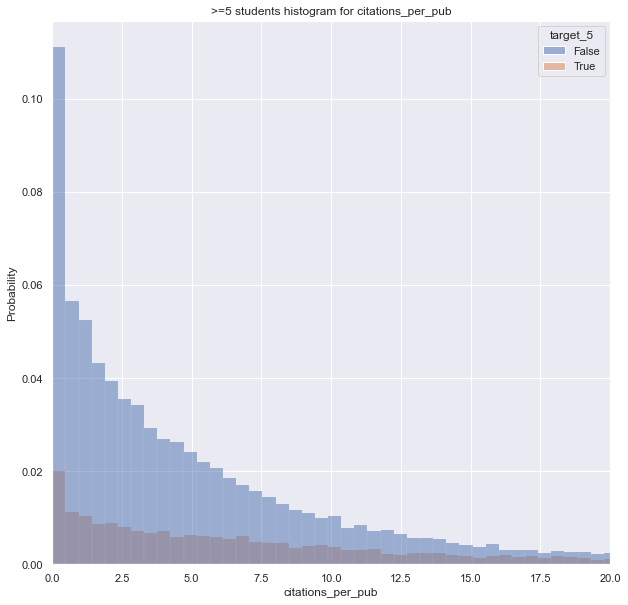

In [26]:
sns.histplot(x = 'citations_per_pub', data=df_school_5, hue='target_5', stat='probability')
plt.xlim(0,20)
plt.title('>=5 students histogram for citations_per_pub')
plt.show()

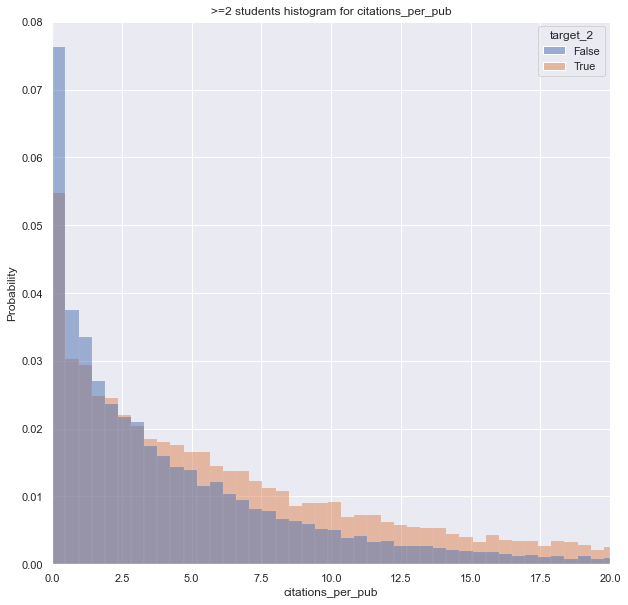

In [27]:
sns.histplot(x = 'citations_per_pub', data=df_school_2, hue='target_2', stat='probability')
plt.xlim(0,20)
plt.title('>=2 students histogram for citations_per_pub')
plt.show()

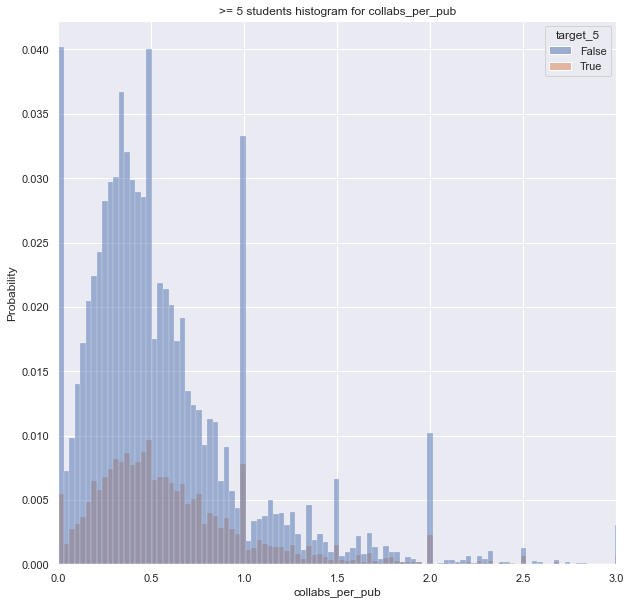

In [28]:
sns.histplot(x = 'collabs_per_pub', data=df_school_5, hue='target_5', stat='probability')
plt.xlim(0,3)
plt.title('>= 5 students histogram for collabs_per_pub')
plt.show()

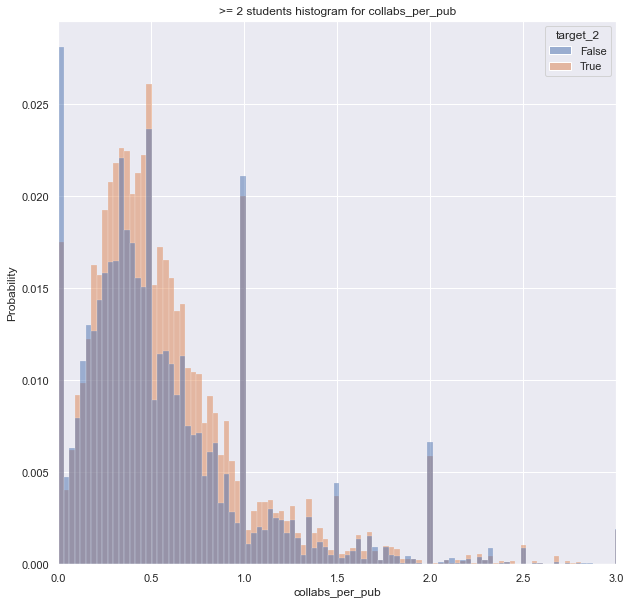

In [29]:
sns.histplot(x = 'collabs_per_pub', data=df_school_2, hue='target_2', stat='probability')
plt.xlim(0,3)
plt.title('>= 2 students histogram for collabs_per_pub')
plt.show()

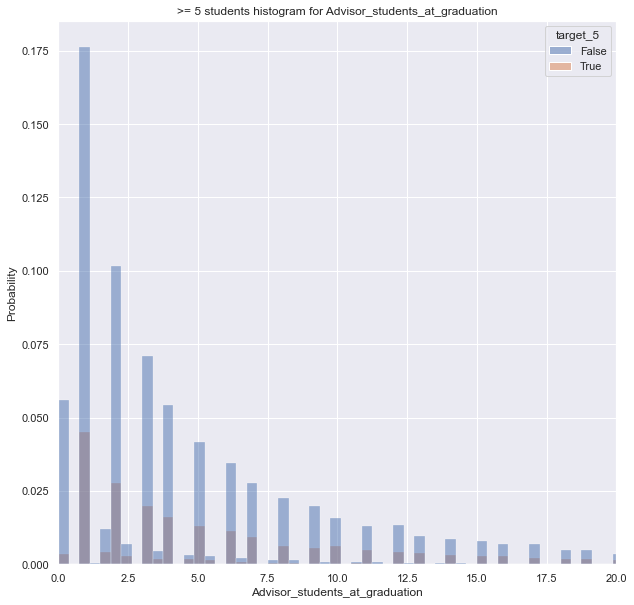

In [30]:
sns.histplot(x = 'Advisor_students_at_graduation', data=df_school_5, hue='target_5', stat='probability')
plt.xlim(0,20)
plt.title('>= 5 students histogram for Advisor_students_at_graduation')
plt.show()

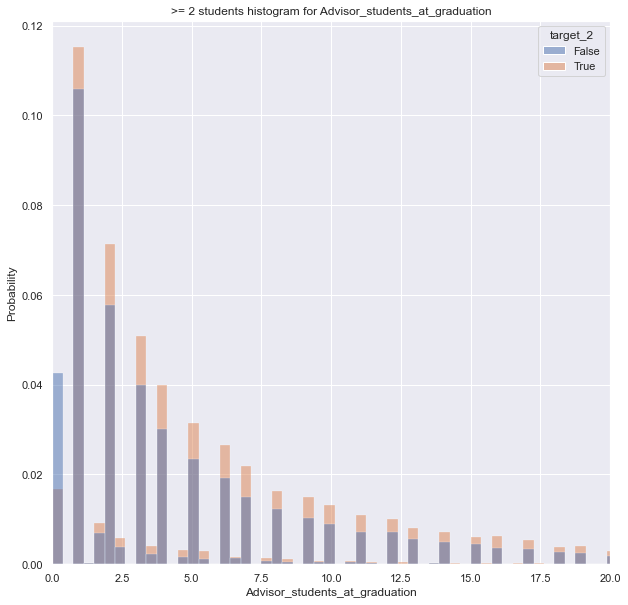

In [31]:
sns.histplot(x = 'Advisor_students_at_graduation', data=df_school_2, hue='target_2', stat='probability')
plt.xlim(0,20)
plt.title('>= 2 students histogram for Advisor_students_at_graduation')
plt.show()

In [4]:
schools125 = ad20.value_counts('School')[:125] 
df_topten = df_school[df_school['School'].apply(lambda C: True if C in list(schools125.index[0:10]) else False)]

In [5]:
schools125 = ad20.value_counts('School')[:125] 
df_topfive = df_school[df_school['School'].apply(lambda C: True if C in list(schools125.index[0:5]) else False)]

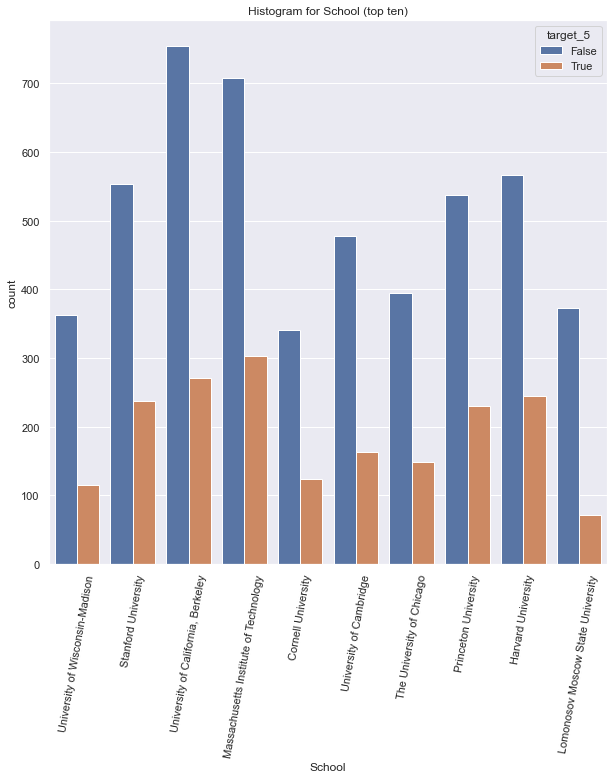

In [35]:
sns.countplot(x = 'School', data=df_topten, hue='target_5')
plt.title('Histogram for School (top ten)')
plt.xticks(rotation=80)
plt.show()

In [6]:
dic = {subject: df_5[subject].sum() for subject in df_5.iloc[:,5:-125].columns}
sums = pd.Series(dic)
top_subs = list(sums.sort_values(ascending=False).head(5).index)

In [41]:
FT_count = {subject: [df_5[df_5['target_5']==False][subject].sum(), df_5[df_5['target_5']==True][subject].sum()] for subject in top_subs}
counts = pd.DataFrame(FT_count)
counts.index=[False,True]
counts

,Numerical analysis,Computer science,Statistics,History and biography,"Operations research, mathematical programming"
False,5045,4816,4792,4359,4461
True,1947,2007,1769,1937,1692


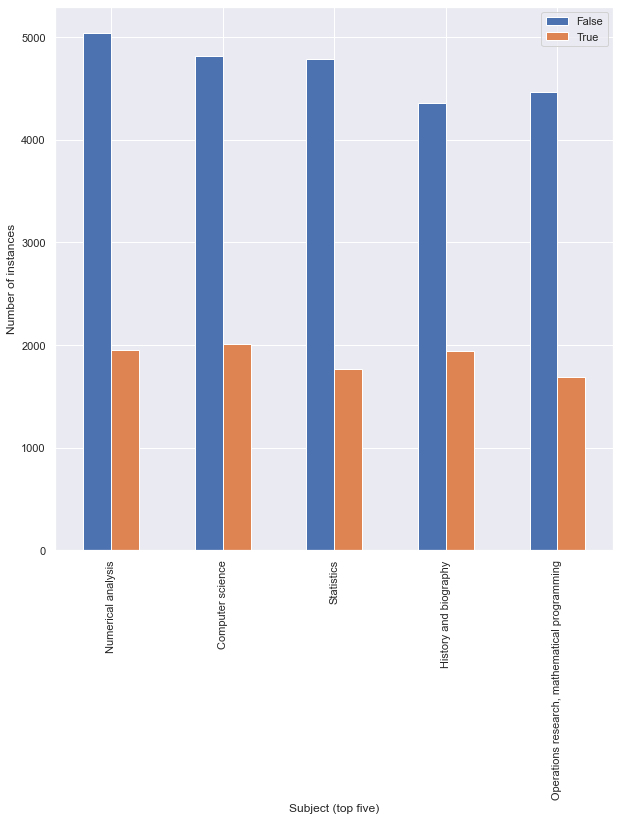

In [42]:
counts.transpose().plot.bar()
plt.xlabel('Subject (top five)')
plt.ylabel('Number of instances')
plt.show()

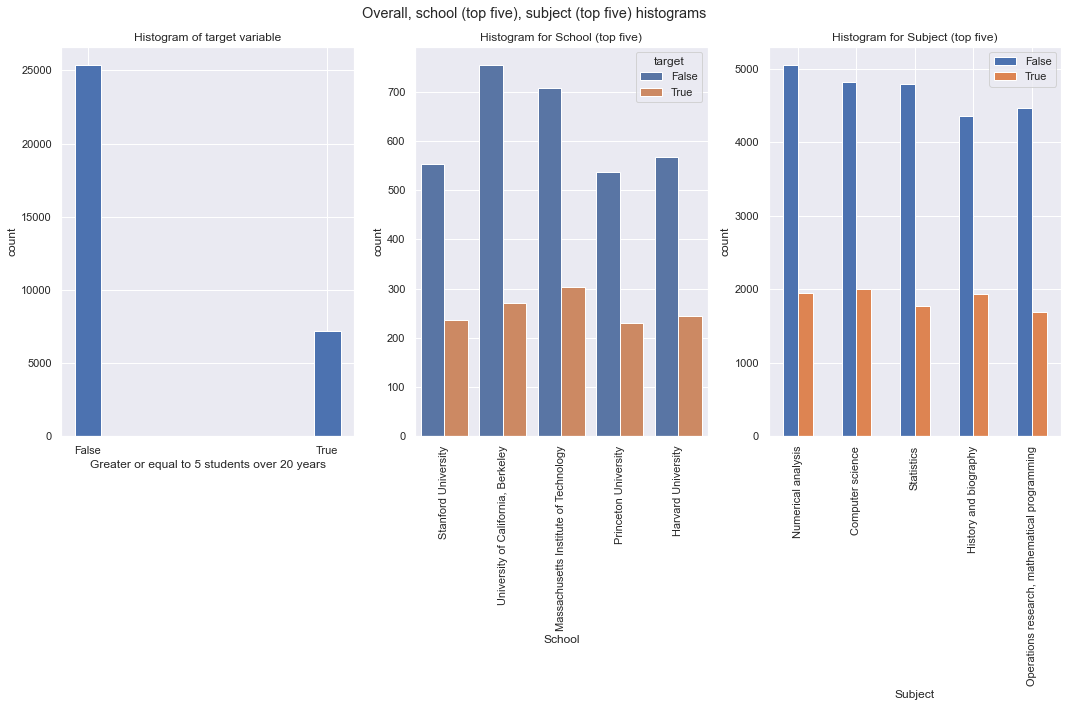

In [78]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Overall, school (top five), subject (top five) histograms')
ax1.hist(df_school.target.astype('int'))
ax1.set(xlabel='Greater or equal to 5 students over 20 years', ylabel='count')
ax1.set_title('Histogram of target variable')
ax1.set_xticks([0.05,0.95])
ax1.set_xticklabels([False,True])
sns.countplot(x = 'School', data=df_topfive, hue='target', ax=ax2)
ax2.set_title('Histogram for School (top five)')
for tick in ax2.get_xticklabels():
        tick.set_rotation(90)
counts.transpose().plot.bar(ax=ax3)
ax3.set(xlabel='Subject', ylabel='count')
ax3.set_title('Histogram for Subject (top five)')
fig.set_figheight(10)
fig.set_figwidth(15)
plt.tight_layout()
plt.savefig('../Report/categorical_hist.jpeg')
plt.show()

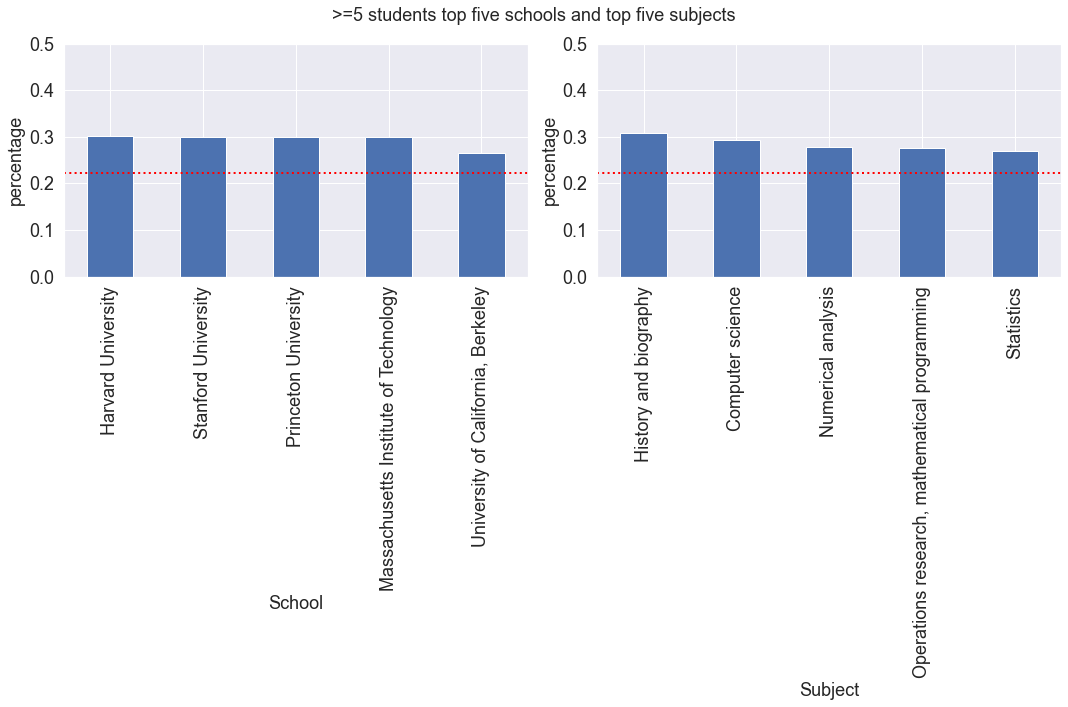

In [9]:
total_true_5 = df_5[df_5['target_5']==True].shape[0]/df_5.shape[0]

def percentage(data,target,col):
    t = data[(data[target]==True)&(data[col]==1)].shape[0]
    total = data[data[col]==1].shape[0]
    return t/total

schools_5 = {school:percentage(df_5,'target_5','School_%s'%(school)) for school in list(schools125.index[0:5])}
schools_5 = dict(sorted(schools_5.items(), key=lambda item: item[1], reverse=True))

subs_5 = {sub:percentage(df_5,'target_5',sub) for sub in top_subs}
subs_5 = dict(sorted(subs_5.items(), key=lambda item: item[1], reverse=True))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('>=5 students top five schools and top five subjects', fontsize=18)
pd.DataFrame(schools_5, index = [0]).transpose().plot.bar(ax=ax1, legend=None, fontsize=18)
ax1.axhline(y=total_true_5,xmin=0,xmax=5,c="red",linestyle='dotted',linewidth=2)
ax1.set_ylim((0,0.5))

ax1.set_ylabel('percentage', fontsize=18)
ax1.set_xlabel(xlabel='School',fontsize=18)
# for tick in ax2.get_xticklabels():
#         tick.set_rotation(90)
pd.DataFrame(subs_5, index=[0]).transpose().plot.bar(ax=ax2, legend=None, fontsize=18)
ax2.axhline(y=total_true_5,xmin=0,xmax=5,c="red",linestyle='dotted',linewidth=2)
ax2.set_ylim((0,0.5))
ax2.set_ylabel('percentage', fontsize=18)
ax2.set_xlabel(xlabel='Subject',fontsize=18)
# plt.setp((ax1,ax2), yticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0, total_true_5],\
#         yticklabels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 'overall'])
fig.set_figheight(10)
fig.set_figwidth(15)
plt.tight_layout()
plt.savefig('../Report/categorical_hist_5.jpeg')
plt.show()

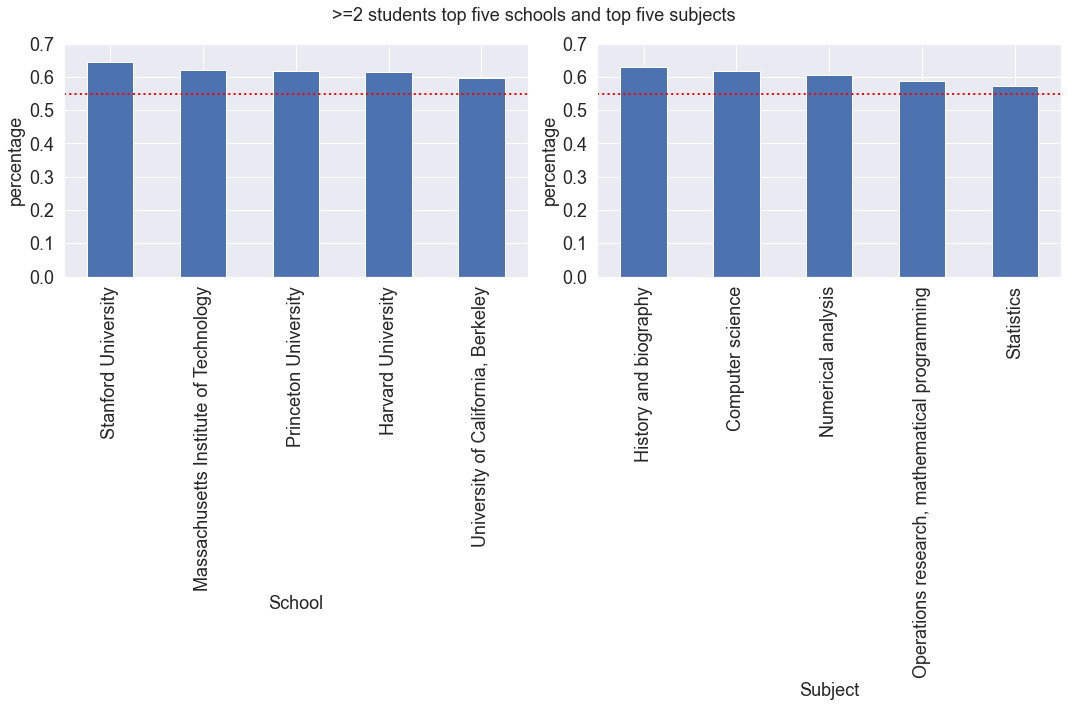

In [10]:
total_true_2 = df_2[df_2['target_2']==True].shape[0]/df_2.shape[0]

def percentage(data,target,col):
    t = data[(data[target]==True)&(data[col]==1)].shape[0]
    total = data[data[col]==1].shape[0]
    return t/total

schools_2 = {school:percentage(df_2,'target_2','School_%s'%(school)) for school in list(schools125.index[0:5])}
schools_2 = dict(sorted(schools_2.items(), key=lambda item: item[1], reverse=True))

subs_2 = {sub:percentage(df_2,'target_2',sub) for sub in top_subs}
subs_2 = dict(sorted(subs_2.items(), key=lambda item: item[1], reverse=True))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('>=2 students top five schools and top five subjects', fontsize=18)
pd.DataFrame(schools_2, index = [0]).transpose().plot.bar(ax=ax1, legend=None, fontsize=18)
ax1.axhline(y=total_true_2,xmin=0,xmax=5,c="red",linestyle='dotted',linewidth=2)
ax1.set_ylim((0,0.7))
ax1.set_ylabel('percentage', fontsize=18)
ax1.set_xlabel(xlabel='School',fontsize=18)
# for tick in ax2.get_xticklabels():
#         tick.set_rotation(90)
pd.DataFrame(subs_2, index=[0]).transpose().plot.bar(ax=ax2, legend=None, fontsize=18)
ax2.axhline(y=total_true_2,xmin=0,xmax=5,c="red",linestyle='dotted',linewidth=2)
ax2.set_ylim((0,0.7))
ax2.set_ylabel('percentage', fontsize=18)
ax2.set_xlabel(xlabel='Subject',fontsize=18)
# plt.setp((ax1,ax2), yticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0, total_true_2],\
#          yticklabels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 'overall'])
fig.set_figheight(10)
fig.set_figwidth(15)
plt.tight_layout()
plt.savefig('../Report/categorical_hist_2.jpeg')
plt.show()

## Hypothesis testing some correlations

In [168]:
schools = set(df_school['School'])

def pvalues(data):
    pv_df = pd.DataFrame({col:data.columns for col in data.columns})
    pv_df.index = data.columns

    for i in range(len(data.columns)):
        for j in range(i+1):
            if j == 0 and i > 0 and i < 5:
                pv_df.iloc[i,j] = stats.pointbiserialr(data.iloc[:,j],data.iloc[:,i])[1]
            elif i == 5 and j == 0:
                pv_df.iloc[i,j] = stats.chi2_contingency(
                    pd.crosstab(
                        data.iloc[:,i],data.iloc[:,j],margins = False
                    )
                )[1]
            elif i == 5 and j> 0 and j < 5:
                pv_df.iloc[i,j] = stats.f_oneway(*[data[data['School'] == school].iloc[:,j] for school in schools])[1]
            elif i == j:
                pv_df.iloc[i,j] = 1    
            elif i > 0 and i < 5 and j > 0 and j < 5:
                pv_df.iloc[i,j] = stats.pearsonr(data.iloc[:,i],data.iloc[:,j])[1]
            elif i == 6 and j in [0,5]:
                pv_df.iloc[i,j] = stats.chi2_contingency(
                    pd.crosstab(
                        data.iloc[:,i],data.iloc[:,j],margins = False
                    )
                )[1]
            elif i == 6 and j>0 and j<5:
                pv_df.iloc[i,j] = stats.pointbiserialr(data.iloc[:,i],data.iloc[:,j])[1]
            elif i == 7 and j in [0,5,6]:
                pv_df.iloc[i,j] = stats.chi2_contingency(
                    pd.crosstab(
                        data.iloc[:,i],data.iloc[:,j],margins = False
                    )
                )[1]
            elif i == 7 and j>0 and j<5:
                pv_df.iloc[i,j] = stats.pointbiserialr(data.iloc[:,i],data.iloc[:,j])[1]

    for i in range(len(data.columns)):
        for j in range(i+1, len(data.columns)):
            pv_df.iloc[i,j] = pv_df.iloc[j,i]

    return pv_df

In [169]:
pvalues(df_school_5)

,target_5,pubs_per_year,citations_per_pub,collabs_per_pub,Advisor_students_at_graduation,School,General applied mathematics,Difference and functional equations
target_5,1,5.97459e-274,1.98968e-155,3.20782e-17,2.55966e-27,8.73331e-67,8.13263e-05,0.012474
pubs_per_year,5.97459e-274,1,4.66455e-271,3.28077e-224,7.18422e-14,5.17767e-202,0.0101828,0
citations_per_pub,1.98968e-155,4.66455e-271,1,6.10509e-89,1.29497e-51,5.59319e-185,0.900087,0.000283656
collabs_per_pub,3.20782e-17,3.28077e-224,6.10509e-89,1,6.88655e-15,7.68375e-224,8.02533e-06,2.999e-49
Advisor_students_at_graduation,2.55966e-27,7.18422e-14,1.29497e-51,6.88655e-15,1,0,0.667227,0.022779
School,8.73331e-67,5.17767e-202,5.59319e-185,7.68375e-224,0,1,3.08491e-06,7.69393e-35
General applied mathematics,8.13263e-05,0.0101828,0.900087,8.02533e-06,0.667227,3.08491e-06,1,2.06713e-11
Difference and functional equations,0.012474,0,0.000283656,2.999e-49,0.022779,7.69393e-35,2.06713e-11,1


In [170]:
pvalues(df_school_2)

,target_2,pubs_per_year,citations_per_pub,collabs_per_pub,Advisor_students_at_graduation,School,Miscellaneous,Mechanics
target_2,1,1.96661e-230,1.38979e-157,9.66974e-07,5.81305e-29,1.09767e-39,0.193602,0.0101152
pubs_per_year,1.96661e-230,1,4.66455e-271,3.28077e-224,7.18422e-14,5.17767e-202,0.518153,0.00039097
citations_per_pub,1.38979e-157,4.66455e-271,1,6.10509e-89,1.29497e-51,5.59319e-185,0.954521,0.220495
collabs_per_pub,9.66974e-07,3.28077e-224,6.10509e-89,1,6.88655e-15,7.68375e-224,0.000196534,4.5004e-16
Advisor_students_at_graduation,5.81305e-29,7.18422e-14,1.29497e-51,6.88655e-15,1,0,0.0080527,0.276297
School,1.09767e-39,5.17767e-202,5.59319e-185,7.68375e-224,0,1,0.963974,2.66073e-16
Miscellaneous,0.193602,0.518153,0.954521,0.000196534,0.0080527,0.963974,1,0.112818
Mechanics,0.0101152,0.00039097,0.220495,4.5004e-16,0.276297,2.66073e-16,0.112818,1


## Regression Analysis of Feature Importance

Function for vif analysis of dataframes.

In [62]:
def vif_analysis(data, target):
    scaler = RobustScaler()
    scaler.fit(data[['pubs_per_year','citations_per_pub','collabs_per_pub','Advisor_students_at_graduation']])
    df_scaled = data.copy()
    df_scaled[['pubs_per_year','citations_per_pub','collabs_per_pub','Advisor_students_at_graduation']] = \
    scaler.transform(data[['pubs_per_year','citations_per_pub','collabs_per_pub','Advisor_students_at_graduation']])

    cols = list(df_scaled.columns)

    for i in range(len(cols)):
        cols[i] = cols[i].replace(' ', '_')
        cols[i] = cols[i].replace(',','')
        cols[i] = cols[i].replace('é','e')
        cols[i] = cols[i].replace('-','_')
        cols[i] = cols[i].replace('.','')
        cols[i] = cols[i].replace('(','')
        cols[i] = cols[i].replace(')','')
        cols[i] = cols[i].replace(';','_')

    df_scaled.columns = cols

    
    #gather features
    features = "+".join(df_scaled.columns[1:])

    # get y and X dataframes based on this regression:
    y_vif, X_vif = dmatrices(target + ' ~' + features, df_scaled, return_type='dataframe')
    X_vif = add_constant(X_vif)

    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    vif["features"] = X_vif.columns

    print('Largest VIF Factor: ', vif.round(1).sort_values('VIF Factor', ascending=False).head(1))

    y_log = df_scaled[target]
    X_scaled_log = add_constant(df_scaled.drop(target,axis=1))

    X_train, X_test, y_train, y_test = train_test_split(X_scaled_log,y_log, stratify=y_log, random_state=2)

    logit_scaled_model = Logit(y_train,X_train)
    logit_scaled_result = logit_scaled_model.fit(maxiter=40)
    scaled_summary = logit_scaled_result.summary()
    scaled_results_as_html = scaled_summary.tables[1].as_html()
    logit_scaled_res = pd.read_html(scaled_results_as_html, header=0, index_col=0)[0]

    # numeric
    print('Numeric coefficients: ', logit_scaled_res.iloc[:5,:].sort_values('coef', ascending=False))
          
    

    # Schools
    print('Largest school coefficient: ', logit_scaled_res.iloc[-125:,:].sort_values('coef', ascending=False).head(1))
    print('Smallest school coefficient: ', logit_scaled_res.iloc[-125:,:].sort_values('coef', ascending=False).tail(1))

    # Subjects
    print('Largest subject coefficient: ', logit_scaled_res.iloc[5:-125,:].sort_values('coef', ascending=False).head(1))
    print('Smallest subject coefficient: ', logit_scaled_res.iloc[5:-125,:].sort_values('coef', ascending=False).tail(1))
          
    X_log = add_constant(data.drop(target,axis=1))
    X_train, X_test, y_train, y_test = train_test_split(X_log,y_log, stratify=y_log, random_state=2)
    logit_model = Logit(y_train,X_train)
    logit_result = logit_model.fit(maxiter=40)
    summary = logit_result.summary()
    results_as_html = summary.tables[1].as_html()
    logit_res = pd.read_html(results_as_html, header=0, index_col=0)[0]
    print('Coefficients for unscaled data: ', logit_res.head(20))  
          
    return logit_scaled_res



### $\geq 5$ students

In [63]:
logit_scaled_res_5 = vif_analysis(df_5, 'target_5')

Largest VIF Factor:     VIF Factor   features
0         6.4  Intercept
Optimization terminated successfully.
         Current function value: 0.479615
         Iterations 7
Numeric coefficients:                                    coef  std err       z  P>|z|  [0.025  0.975]
pubs_per_year                   0.4516    0.021  21.172  0.000   0.410   0.493
collabs_per_pub                 0.2078    0.016  13.380  0.000   0.177   0.238
citations_per_pub               0.1702    0.013  13.379  0.000   0.145   0.195
Advisor_students_at_graduation  0.0338    0.013   2.673  0.008   0.009   0.059
const                          -2.2364    0.045 -49.890  0.000  -2.324  -2.149
Largest school coefficient:                                                 coef  std err      z  P>|z|  \
School_Johannes_Gutenberg_Universität_Mainz  1.3058    0.338  3.863    0.0   

                                             [0.025  0.975]  
School_Johannes_Gutenberg_Universität_Mainz   0.643   1.968  
Smallest school coef

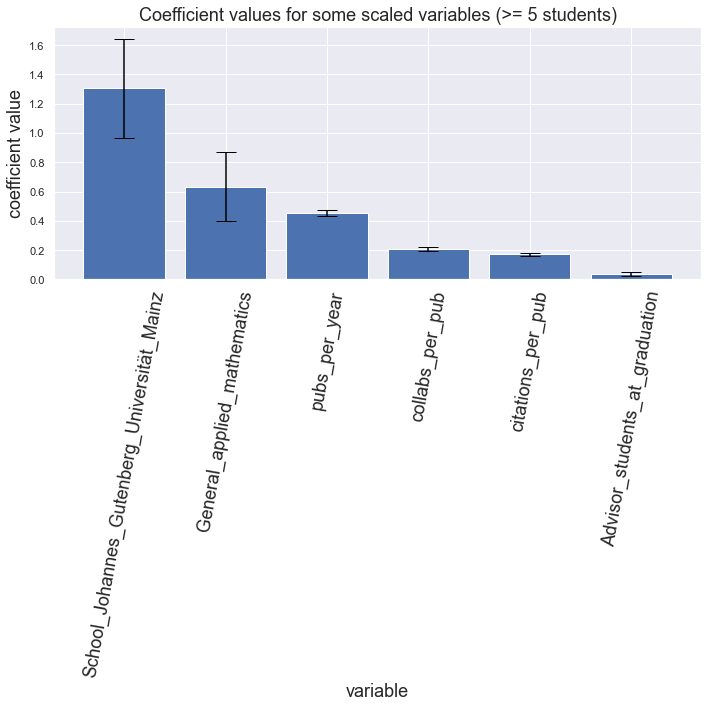

In [64]:
variables = ['School_Johannes_Gutenberg_Universität_Mainz','General_applied_mathematics','pubs_per_year','collabs_per_pub','citations_per_pub','Advisor_students_at_graduation']

means = [logit_scaled_res_5.loc[variable,'coef'] for variable in variables]

std = [logit_scaled_res_5.loc[variable,'std err'] for variable in variables]

plt.bar(variables, means, yerr=std, align='center', ecolor='black', capsize=10)
plt.title('Coefficient values for some scaled variables (>= 5 students)', fontsize=18)
plt.xlabel('variable', fontsize=18)
plt.ylabel('coefficient value', fontsize=18)
plt.xticks(rotation=80, fontsize=18)
plt.tight_layout()
plt.savefig('../Report/variable_importances_5.jpeg')
plt.show()
    

### $\geq 2$ students

In [65]:
logit_res_scaled_2 = vif_analysis(df_2,'target_2')

Largest VIF Factor:     VIF Factor   features
0         6.4  Intercept
Optimization terminated successfully.
         Current function value: 0.642099
         Iterations 6
Numeric coefficients:                                    coef  std err       z  P>|z|  [0.025  0.975]
pubs_per_year                   0.5009    0.023  21.619    0.0   0.455   0.546
citations_per_pub               0.2033    0.014  14.159    0.0   0.175   0.231
collabs_per_pub                 0.1230    0.014   9.090    0.0   0.097   0.150
Advisor_students_at_graduation  0.0408    0.011   3.615    0.0   0.019   0.063
const                          -0.3955    0.035 -11.357    0.0  -0.464  -0.327
Largest school coefficient:                                                      coef  std err      z  \
School_Westfälische_Wilhelms_Universität_Münster  0.9582    0.247  3.877   

                                                  P>|z|  [0.025  0.975]  
School_Westfälische_Wilhelms_Universität_Münster    0.0   0.474   1.443  


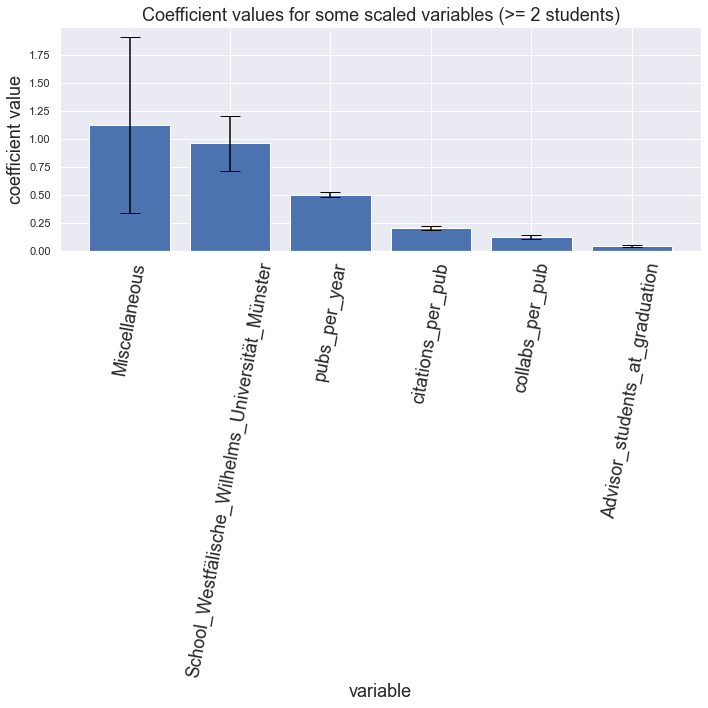

In [66]:
variables = ['Miscellaneous','School_Westfälische_Wilhelms_Universität_Münster','pubs_per_year','citations_per_pub','collabs_per_pub','Advisor_students_at_graduation']

means = [logit_res_scaled_2.loc[variable,'coef'] for variable in variables]

std = [logit_res_scaled_2.loc[variable,'std err'] for variable in variables]

plt.bar(variables, means, yerr=std, align='center', ecolor='black', capsize=10)
plt.title('Coefficient values for some scaled variables (>= 2 students)', fontsize=18)
plt.xlabel('variable', fontsize=18)
plt.ylabel('coefficient value', fontsize=18)
plt.xticks(rotation=80, fontsize=18)
plt.tight_layout()
plt.savefig('../Report/variable_importances_2.jpeg')
plt.show()
    